<a href="https://colab.research.google.com/github/Lluvia-kys/vitiligo/blob/main/vitiligo_training_colab_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Vitiligo Classification with Mask-Guided Attention (Colab A100-friendly)

This notebook implements a dual-branch CNN for vitiligo stage classification (stable vs progressive) using mask-guided attention:

- Two vision branches (Wood's lamp and clinical images) using MobileNetV2 backbones
- A segmentation model to generate lesion masks that guide attention
- A lightweight classifier head on fused features
- Training/validation loops with mixed precision and GPU-friendly settings

Prerequisites:
- Dataset structure on Google Drive (or local): two folders `stable_stage_patient` and `progressive_stage_patient`, each containing patient/visit subfolders with at least two images per visit
- Pretrained segmentation checkpoint file for the mask generator

You can run this in Google Colab (A100 recommended) or locally. The notebook will try to auto-detect Colab and mount Google Drive; otherwise, set local paths via environment variables or edit the path cell.


## 1. Setup and Imports

This section:
- Imports core libraries (PyTorch, torchvision, numpy, etc.)
- Enables warnings filter for a cleaner log
- Detects if running on Google Colab, and mounts Google Drive when applicable


In [ ]:
# Setup and Imports
import os
import sys
import copy
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from torchvision import transforms, models
from torchvision.transforms import functional as TF
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Reproducibility
def set_seed(seed: int = 42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

set_seed(42)

# Detect Colab and mount Drive if available
RUNNING_IN_COLAB = 'google.colab' in sys.modules
if RUNNING_IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

# Set default device and GPU-friendly settings
if torch.cuda.is_available():
  device = torch.device('cuda')
  print(f"✅ GPU Available: {torch.cuda.get_device_name(0)}")
  print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
  print(f"   CUDA Version: {torch.version.cuda}")
  torch.backends.cuda.matmul.allow_tf32 = True
  torch.backends.cudnn.allow_tf32 = True
  torch.backends.cudnn.benchmark = True
  torch.backends.cudnn.deterministic = False
else:
  device = torch.device('cpu')
  print("⚠️ No GPU available, using CPU")


Mounted at /content/drive
✅ GPU Available: NVIDIA A100-SXM4-40GB
   Memory: 42.47 GB
   CUDA Version: 12.4


## 2. Paths and Configuration

- Set dataset, checkpoint, and results directories
- Creates the results directory if missing


In [ ]:
DATA_DIR = '/content/drive/MyDrive/vitiligo/data'
SEG_MODEL_PATH = '/content/drive/MyDrive/vitiligo/results_seg/pretrained_segmentation_best.pth'
SAVE_DIR = '/content/drive/MyDrive/vitiligo/results/v2'

os.makedirs(SAVE_DIR, exist_ok=True)
print(f"Results will be saved to: {os.path.abspath(SAVE_DIR)}")


Results will be saved to: /content/drive/MyDrive/vitiligo/results/v2


## 3. Models

We define:
- A lightweight U-Net with a ResNet18 backbone to generate lesion masks (segmentation)
- A mask-guided attention module to modulate features using the predicted masks
- A dual-branch CNN with MobileNetV2 backbones for Wood's lamp and clinical images

The segmentation model is loaded from a pretrained checkpoint.


In [ ]:
class ResNetUNet(nn.Module):
  """U-Net with ResNet18 backbone for segmentation"""
  def __init__(self, out_channels=1, pretrained=True):
      super(ResNetUNet, self).__init__()
      resnet = models.resnet18(pretrained=pretrained)

      self.enc0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)
      self.pool = nn.MaxPool2d(2)
      self.enc1 = resnet.layer1
      self.enc2 = resnet.layer2
      self.enc3 = resnet.layer3
      self.enc4 = resnet.layer4

      self.up4 = nn.ConvTranspose2d(512, 256, 2, stride=2)
      self.dec4 = self._dec_block(512, 256)

      self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
      self.dec3 = self._dec_block(256, 128)

      self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
      self.dec2 = self._dec_block(128, 64)

      self.up1 = nn.ConvTranspose2d(64, 64, 2, stride=2)
      self.dec1 = self._dec_block(128, 64)

      self.final = nn.Conv2d(64, out_channels, 1)

  def _dec_block(self, in_ch, out_ch):
      return nn.Sequential(
          nn.Conv2d(in_ch, out_ch, 3, padding=1),
          nn.BatchNorm2d(out_ch),
          nn.ReLU(inplace=True),
          nn.Conv2d(out_ch, out_ch, 3, padding=1),
          nn.BatchNorm2d(out_ch),
          nn.ReLU(inplace=True),
      )

  def forward(self, x):
      h, w = x.shape[2], x.shape[3]
      e0 = self.enc0(x)
      e1_in = self.pool(e0)
      e1 = self.enc1(e1_in)
      e2 = self.enc2(e1)
      e3 = self.enc3(e2)
      e4 = self.enc4(e3)

      d4 = self.up4(e4)
      d4 = torch.cat([d4, e3], dim=1)
      d4 = self.dec4(d4)

      d3 = self.up3(d4)
      d3 = torch.cat([d3, e2], dim=1)
      d3 = self.dec3(d3)

      d2 = self.up2(d3)
      d2 = torch.cat([d2, e1], dim=1)
      d2 = self.dec2(d2)

      d1 = self.up1(d2)
      d1 = torch.cat([d1, e0], dim=1)
      d1 = self.dec1(d1)

      out = self.final(d1)
      out = F.interpolate(out, size=(h, w), mode='bilinear', align_corners=False)
      return out


class MaskPredictor:
  """Mask predictor using a pretrained segmentation model.

  - Safe for DataLoader workers: keeps CPU inference inside workers.
  - If called from the main process and CUDA is available, it can use GPU with AMP.
  - On A100 (SM >= 80) autocast uses bfloat16; otherwise float16.
  """
  def __init__(self, model_path, device, use_amp: bool = True):
      # Record the preferred device, but initialize the model on CPU to avoid CUDA in workers
      if isinstance(device, str):
          self.preferred_device = torch.device(device)
      elif isinstance(device, torch.device):
          self.preferred_device = device
      else:
          self.preferred_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

      self.device = torch.device('cpu')
      self.model = ResNetUNet(out_channels=1, pretrained=False).to(self.device)

      # Robust checkpoint loading
      checkpoint = torch.load(model_path, map_location='cpu')
      state_dict = checkpoint['model_state_dict'] if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint else checkpoint
      self.model.load_state_dict(state_dict)
      self.model.eval()

      # AMP dtype preference (decided at runtime when using CUDA)
      self.use_amp = bool(use_amp)
      self.amp_dtype = None
      if torch.cuda.is_available():
          major, _ = torch.cuda.get_device_capability(0)
          self.amp_dtype = torch.bfloat16 if major >= 8 else torch.float16

      # Preprocessing
      self.seg_transform = transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
      ])

      # Log
      if self.preferred_device.type == 'cuda' and torch.cuda.is_available():
          try:
              dev_name = torch.cuda.get_device_name(0)
          except Exception:
              dev_name = 'CUDA device'
          print(f"✅ Mask predictor initialized (CPU model loaded; will use GPU '{dev_name}' with AMP={self.use_amp} when called from main process).")
      else:
          print(f"✅ Mask predictor loaded on CPU from: {model_path}")

  def _maybe_move_to_cuda(self):
      if self.device.type != 'cuda' and self.preferred_device.type == 'cuda' and torch.cuda.is_available():
          # Use channels_last for better memory access on Ampere
          self.model.to(memory_format=torch.channels_last)
          self.model = self.model.to('cuda')
          self.device = torch.device('cuda')

  @torch.no_grad()
  def predict_mask(self, wood_image):
      """Predict mask for Wood's lamp image.

      Uses CPU inside DataLoader workers. Uses preferred CUDA device in the main process.
      """
      # If running inside a worker, force CPU
      worker_info = torch.utils.data.get_worker_info()
      if worker_info is None:
          # main process: allow CUDA move if requested
          self._maybe_move_to_cuda()
      else:
          # ensure CPU in workers
          if self.device.type != 'cpu':
              self.model = self.model.to('cpu')
              self.device = torch.device('cpu')

      # Preprocess input
      input_tensor = self.seg_transform(wood_image).unsqueeze(0)
      if self.device.type == 'cuda':
          input_tensor = input_tensor.to(self.device, non_blocking=True, memory_format=torch.channels_last)
          if self.use_amp and self.amp_dtype is not None:
              with autocast(enabled=True, dtype=self.amp_dtype):
                  pred = self.model(input_tensor)
          else:
              pred = self.model(input_tensor)
      else:
          pred = self.model(input_tensor.to(self.device))

      mask = torch.sigmoid(pred).squeeze(0).cpu()
      return mask


class MaskGuidedAttention(nn.Module):
  """Mask-guided attention module"""
  def __init__(self, feature_channels=1280):
      super(MaskGuidedAttention, self).__init__()
      self.feature_channels = feature_channels

      self.mask_conv = nn.Sequential(
          nn.Conv2d(1, 64, kernel_size=3, padding=1),
          nn.ReLU(inplace=True),
          nn.Conv2d(64, 128, kernel_size=3, padding=1),
          nn.ReLU(inplace=True),
          nn.Conv2d(128, feature_channels, kernel_size=1),
          nn.Sigmoid()
      )

      self.enhance_conv = nn.Sequential(
          nn.Conv2d(feature_channels, feature_channels, kernel_size=1),
          nn.ReLU(inplace=True),
          nn.Conv2d(feature_channels, feature_channels, kernel_size=1),
          nn.Sigmoid()
      )

  def forward(self, features, mask):
      mask_resized = F.interpolate(mask, size=features.shape[2:],
                                  mode='bilinear', align_corners=False)
      mask_attention = self.mask_conv(mask_resized)
      attended_features = features * mask_attention
      enhancement = self.enhance_conv(attended_features)
      final_features = features * enhancement + attended_features
      return final_features


class DualBranchCNN(nn.Module):
  """Dual-branch CNN with mask-guided attention"""
  def __init__(self, pretrained=True):
      super(DualBranchCNN, self).__init__()

      self.wood_branch = models.mobilenet_v2(pretrained=pretrained).features
      self.clinical_branch = models.mobilenet_v2(pretrained=pretrained).features

      self.wood_attention = MaskGuidedAttention(feature_channels=1280)
      self.clinical_attention = MaskGuidedAttention(feature_channels=1280)

      self.pool = nn.AdaptiveAvgPool2d((1, 1))

      # Increased dropout for stronger regularization
      self.classifier = nn.Sequential(
          nn.Linear(1280 * 2, 512),
          nn.ReLU(),
          nn.Dropout(0.6),
          nn.Linear(512, 256),
          nn.ReLU(),
          nn.Dropout(0.5),
          nn.Linear(256, 2)
      )

  def forward(self, wood_img, clinical_img, wood_mask, clinical_mask):
      w_features = self.wood_branch(wood_img)
      w_features = self.wood_attention(w_features, wood_mask)
      w = self.pool(w_features).flatten(1)

      c_features = self.clinical_branch(clinical_img)
      c_features = self.clinical_attention(c_features, clinical_mask)
      c = self.pool(c_features).flatten(1)

      fused = torch.cat([w, c], dim=1)
      out = self.classifier(fused)
      return out


## 4. Dataset and Data Loading

The dataset loader:
- Traverses a directory structure organized by stage/patient/visit
- Groups images in pairs per visit (Wood's lamp + clinical)
- Automatically detects the Wood's lamp image by brightness/blue ratio
- Generates lesion masks via the segmentation model

A helper also splits the dataset into train/val sets with balanced class splits.


In [ ]:
def is_wood_lamp(image: Image.Image) -> bool:
  img_np = np.array(image)
  # Assuming RGB image, blue channel is at index 2, red at index 0
  blue_ratio = np.mean(img_np[:, :, 2]) / (np.mean(img_np[:, :, 0]) + 1e-5)

  # Refined threshold based on testing.
  return blue_ratio > 1.39  # Adjusted threshold(see further details on tuning)


class VitiligoDataset(Dataset):
  """Vitiligo dataset with automatic Wood's lamp detection and mask prediction.
  Adds train/val-aware joint augmentations that preserve mask alignment.
  """
  def __init__(self, root_dir, transform=None, samples=None, mask_predictor=None,
               is_train: bool = False, img_size: int = 224):
      self.transform = transform  # kept for compatibility; not used for spatial ops
      self.mask_predictor = mask_predictor
      self.class_map = {'stable_stage_patient': 0, 'progressive_stage_patient': 1}
      self.is_train = is_train
      self.img_size = img_size
      self.mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
      self.std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

      if samples is not None:
          self.samples = samples
      else:
          self.samples = []
          for stage_dir in os.listdir(root_dir):
              full_stage_path = os.path.join(root_dir, stage_dir)
              if not os.path.isdir(full_stage_path):
                  continue

              for patient_id in os.listdir(full_stage_path):
                  patient_path = os.path.join(full_stage_path, patient_id)
                  if not os.path.isdir(patient_path):
                      continue

                  for visit in os.listdir(patient_path):
                      visit_path = os.path.join(patient_path, visit)
                      if not os.path.isdir(visit_path):
                          continue

                      images = [f for f in os.listdir(visit_path)
                                if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

                      if len(images) < 2:
                          continue

                      # Group images in pairs
                      for i in range(0, len(images), 2):
                          if i + 1 < len(images):
                              img_paths = [
                                  os.path.join(visit_path, images[i]),
                                  os.path.join(visit_path, images[i + 1])
                              ]
                              self.samples.append((img_paths, self.class_map[stage_dir]))

  def __len__(self):
      return len(self.samples)

  def _normalize(self, img_tensor: torch.Tensor) -> torch.Tensor:
      return (img_tensor - self.mean) / self.std

  def _train_joint_augment(self, w: torch.Tensor, c: torch.Tensor, m: torch.Tensor):
      # RandomResizedCrop shared params
      i, j, h, k = transforms.RandomResizedCrop.get_params(w, scale=(0.7, 1.0), ratio=(0.75, 1.333))
      size = [self.img_size, self.img_size]
      w = TF.resized_crop(w, i, j, h, k, size=size)
      c = TF.resized_crop(c, i, j, h, k, size=size)
      m = TF.resized_crop(m, i, j, h, k, size=size)

      # Flips
      if random.random() < 0.5:
          w = TF.hflip(w); c = TF.hflip(c); m = TF.hflip(m)
      if random.random() < 0.2:
          w = TF.vflip(w); c = TF.vflip(c); m = TF.vflip(m)

      # Rotation
      angle = random.uniform(-20, 20)
      w = TF.rotate(w, angle)
      c = TF.rotate(c, angle)
      m = TF.rotate(m, angle)

      # Color jitter on images only
      jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02)
      w = jitter(w)
      c = jitter(c)

      # Optional blur
      if random.random() < 0.2:
          blur = transforms.GaussianBlur(3)
          w = blur(w)
          c = blur(c)

      return w, c, m

  def _val_joint_transform(self, w: torch.Tensor, c: torch.Tensor, m: torch.Tensor):
      resize_size = int(self.img_size * 1.14)
      w = TF.resize(w, resize_size, antialias=True)
      c = TF.resize(c, resize_size, antialias=True)
      m = TF.resize(m, resize_size, antialias=True)
      w = TF.center_crop(w, [self.img_size, self.img_size])
      c = TF.center_crop(c, [self.img_size, self.img_size])
      m = TF.center_crop(m, [self.img_size, self.img_size])
      return w, c, m

  def __getitem__(self, idx):
      img_paths, label = self.samples[idx]
      images = [Image.open(p).convert('RGB') for p in img_paths]

      # Detect Wood's lamp image
      if is_wood_lamp(images[0]):
          wood_img_pil, clinical_img_pil = images[0], images[1]
      else:
          wood_img_pil, clinical_img_pil = images[1], images[0]

      # Predict mask (from original wood image)
      predicted_mask = None
      if self.mask_predictor:
          try:
              predicted_mask = self.mask_predictor.predict_mask(wood_img_pil)
          except Exception as e:
              print(f"Warning: Mask prediction failed: {e}")
              predicted_mask = None

      if predicted_mask is None:
          predicted_mask = torch.zeros(1, self.img_size, self.img_size)

      # Convert to tensors in [0,1]
      wood_img = TF.to_tensor(wood_img_pil)
      clinical_img = TF.to_tensor(clinical_img_pil)
      mask = predicted_mask  # already tensor (1,H,W)

      # Joint spatial transforms to preserve alignment
      if self.is_train:
          wood_img, clinical_img, mask = self._train_joint_augment(wood_img, clinical_img, mask)
      else:
          wood_img, clinical_img, mask = self._val_joint_transform(wood_img, clinical_img, mask)

      # Normalize images
      wood_img = self._normalize(wood_img)
      clinical_img = self._normalize(clinical_img)

      return wood_img, clinical_img, label, mask, mask


def split_dataset_by_class(root_dir, val_ratio=0.2, random_state=42):
  """Split dataset by class for balanced validation."""
  all_samples = []
  class_map = {'stable_stage_patient': 0, 'progressive_stage_patient': 1}

  for stage_dir in os.listdir(root_dir):
      full_stage_path = os.path.join(root_dir, stage_dir)
      if not os.path.isdir(full_stage_path):
          continue

      stage_samples = []
      for patient_id in os.listdir(full_stage_path):
          patient_path = os.path.join(full_stage_path, patient_id)
          if not os.path.isdir(patient_path):
              continue

          for visit in os.listdir(patient_path):
              visit_path = os.path.join(patient_path, visit)
              if not os.path.isdir(visit_path):
                  continue

              images = [f for f in os.listdir(visit_path)
                        if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

              if len(images) < 2:
                  continue

              for i in range(0, len(images), 2):
                  if i + 1 < len(images):
                      img_paths = [
                          os.path.join(visit_path, images[i]),
                          os.path.join(visit_path, images[i + 1])
                      ]
                      stage_samples.append((img_paths, class_map[stage_dir]))

      if len(stage_samples) > 0:
          train_samples, val_samples = train_test_split(
              stage_samples, test_size=val_ratio, random_state=random_state
          )
          all_samples.extend([('train', sample) for sample in train_samples])
          all_samples.extend([('val', sample) for sample in val_samples])

          print(f"{stage_dir}: Train {len(train_samples)}, Val {len(val_samples)}")

  train_samples = [sample[1] for sample in all_samples if sample[0] == 'train']
  val_samples = [sample[1] for sample in all_samples if sample[0] == 'val']

  return train_samples, val_samples


## 5. Training and Validation

This section defines:
- Metric utilities (accuracy, specificity, sensitivity)
- Training and validation loops with mixed precision
- Visualization helpers to plot history and confusion matrix


In [ ]:
class MetricTracker:
    """Track training metrics for visualization"""
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []
        self.train_specs = []
        self.val_specs = []
        self.train_sens = []
        self.val_sens = []
        self.best_val_acc = 0
        self.best_epoch = 0

    def update(self, train_loss, val_loss, train_acc, val_acc, train_spec, val_spec, train_sens, val_sens, epoch):
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.train_accs.append(train_acc)
        self.val_accs.append(val_acc)
        self.train_specs.append(train_spec)
        self.val_specs.append(val_spec)
        self.train_sens.append(train_sens)
        self.val_sens.append(val_sens)

        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            self.best_epoch = epoch


def calculate_metrics(y_true, y_pred):
    """Calculate accuracy, specificity, and sensitivity from confusion matrix."""
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
    else:
        # Fallback to avoid crashes in rare degenerate batches
        tn = fp = fn = tp = 0
    accuracy = (tp + tn) / max(1, (tp + tn + fp + fn))
    specificity = tn / max(1, (tn + fp))
    sensitivity = tp / max(1, (tp + fn))
    return accuracy, specificity, sensitivity, tp, tn, fp, fn


def mixup_batch(wood_img, clinical_img, wood_mask, clinical_mask, labels, alpha=0.4):
    if alpha <= 0:
        return wood_img, clinical_img, wood_mask, clinical_mask, labels, labels, 1.0
    lam = np.random.beta(alpha, alpha)
    batch_size = wood_img.size(0)
    index = torch.randperm(batch_size, device=wood_img.device)
    w = lam * wood_img + (1 - lam) * wood_img[index]
    c = lam * clinical_img + (1 - lam) * clinical_img[index]
    wm = lam * wood_mask + (1 - lam) * wood_mask[index]
    cm = lam * clinical_mask + (1 - lam) * clinical_mask[index]
    y_a, y_b = labels, labels[index]
    return w, c, wm, cm, y_a, y_b, lam


def train_epoch(model, dataloader, criterion, optimizer, scaler, device, max_grad_norm: float = 2.0, mixup_alpha: float = 0.0):
    """Train for one epoch with mixed precision, optional MixUp, and gradient clipping."""
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    pbar = tqdm(dataloader, desc='Training')
    for batch_data in pbar:
        wood_img, clinical_img, labels, wood_mask, clinical_mask = batch_data

        wood_img = wood_img.to(device, non_blocking=True)
        clinical_img = clinical_img.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        wood_mask = wood_mask.to(device, non_blocking=True)
        clinical_mask = clinical_mask.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with autocast():
            if mixup_alpha and mixup_alpha > 0:
                w, c, wm, cm, y_a, y_b, lam = mixup_batch(
                    wood_img, clinical_img, wood_mask, clinical_mask, labels, alpha=mixup_alpha
                )
                outputs = model(w, c, wm, cm)
                loss = lam * criterion(outputs, y_a) + (1 - lam) * criterion(outputs, y_b)
                y_for_metrics = labels
            else:
                outputs = model(wood_img, clinical_img, wood_mask, clinical_mask)
                loss = criterion(outputs, labels)
                y_for_metrics = labels

        scaler.scale(loss).backward()
        # Unscale before clipping so clip works with AMP
        scaler.unscale_(optimizer)
        if max_grad_norm is not None and max_grad_norm > 0:
            nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        scaler.step(optimizer)
        scaler.update()

        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_for_metrics.cpu().numpy())
        running_loss += loss.item()
        pbar.set_postfix({'loss': loss.item()})

    avg_loss = running_loss / len(dataloader)
    accuracy, specificity, sensitivity, tp, tn, fp, fn = calculate_metrics(all_labels, all_preds)
    return avg_loss, accuracy, specificity, sensitivity


def validate_epoch(model, dataloader, criterion, device):
    """Validate model performance."""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_data in tqdm(dataloader, desc='Validation'):
            wood_img, clinical_img, labels, wood_mask, clinical_mask = batch_data

            wood_img = wood_img.to(device, non_blocking=True)
            clinical_img = clinical_img.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            wood_mask = wood_mask.to(device, non_blocking=True)
            clinical_mask = clinical_mask.to(device, non_blocking=True)

            with autocast():
                outputs = model(wood_img, clinical_img, wood_mask, clinical_mask)
                loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    accuracy, specificity, sensitivity, tp, tn, fp, fn = calculate_metrics(all_labels, all_preds)
    return avg_loss, accuracy, specificity, sensitivity, all_labels, all_preds


def plot_training_history(metrics):
    """Plot comprehensive training history."""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    epochs = range(1, len(metrics.train_losses) + 1)

    axes[0, 0].plot(epochs, metrics.train_losses, 'b-', label='Train Loss')
    axes[0, 0].plot(epochs, metrics.val_losses, 'r-', label='Val Loss')
    axes[0, 0].set_title('Loss Over Epochs', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].plot(epochs, metrics.train_accs, 'b-', label='Train Acc')
    axes[0, 1].plot(epochs, metrics.val_accs, 'r-', label='Val Acc')
    axes[0, 1].axhline(y=metrics.best_val_acc, color='g', linestyle='--',
                      label=f'Best Val Acc: {metrics.best_val_acc:.4f}')
    axes[0, 1].set_title('Accuracy Over Epochs', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    axes[0, 2].plot(epochs, metrics.train_specs, 'b-', label='Train Spec')
    axes[0, 2].plot(epochs, metrics.val_specs, 'r-', label='Val Spec')
    axes[0, 2].set_title('Specificity Over Epochs', fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Specificity')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    loss_diff = [v - t for t, v in zip(metrics.train_losses, metrics.val_losses)]
    axes[1, 0].plot(epochs, loss_diff, 'g-')
    axes[1, 0].axhline(y=0, color='r', linestyle='--')
    axes[1, 0].set_title('Val Loss - Train Loss (Overfitting Indicator)',
                        fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss Difference')
    axes[1, 0].grid(True, alpha=0.3)

    # LR curve placeholder kept, will be used by TensorBoard or explicit logging if added
    axes[1, 1].text(0.5, 0.5, 'Learning Rate Schedule\n(see TensorBoard run dir)',
                   ha='center', va='center', fontsize=12)
    axes[1, 1].set_title('Learning Rate', fontsize=14, fontweight='bold')
    axes[1, 1].axis('off')

    summary_text = f"""
    Best Validation Accuracy: {metrics.best_val_acc:.4f} (Epoch {metrics.best_epoch})
    Final Train Accuracy: {metrics.train_accs[-1]:.4f}
    Final Val Accuracy: {metrics.val_accs[-1]:.4f}
    Final Train Loss: {metrics.train_losses[-1]:.4f}
    Final Val Loss: {metrics.val_losses[-1]:.4f}
    """
    axes[1, 2].text(0.1, 0.5, summary_text, fontsize=11, verticalalignment='center')
    axes[1, 2].set_title('Summary Statistics', fontsize=14, fontweight='bold')
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, 'training_history.png'), dpi=150, bbox_inches='tight')
    plt.show()


def plot_confusion_matrix(y_true, y_pred, class_names=['Stable', 'Progressive']):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j + 0.5, i + 0.7, f'{cm_normalized[i, j]:.1%}',
                     ha='center', va='center', fontsize=10, color='red')

    plt.savefig(os.path.join(SAVE_DIR, 'confusion_matrix.png'), dpi=150, bbox_inches='tight')
    plt.show()


## 6. Training Entry Point

The main function configures data, model, optimizer, scheduler, and runs the train/validate loops. It also saves the best checkpoint and produces visualizations and a classification report.


In [ ]:
def train_vitiligo_model(
    epochs=3,
    batch_size=32,
    learning_rate=1e-4,
    val_ratio=0.2,
    num_workers=0,
    resume_from=None,
    pretrained=True,
    reset_optimizer=False
):
    """Main training function with overfitting guards and stronger regularization."""

    print("=" * 70)
    print("🚀 VITILIGO CLASSIFICATION WITH MASK-GUIDED ATTENTION")
    print("=" * 70)

    # Initialize mask predictor
    print("\n📋 Loading segmentation model...")
    mask_predictor = MaskPredictor(SEG_MODEL_PATH, device)

    img_size = 224

    # Dataset split
    print("\n📊 Splitting dataset...")
    train_samples, val_samples = split_dataset_by_class(DATA_DIR, val_ratio=val_ratio)
    print(f"Total: {len(train_samples)} train samples, {len(val_samples)} val samples")

    # Create datasets with train/val-aware transforms (joint augmentations inside)
    train_dataset = VitiligoDataset(
        root_dir=None, transform=None,
        samples=train_samples, mask_predictor=mask_predictor,
        is_train=True, img_size=img_size
    )
    val_dataset = VitiligoDataset(
        root_dir=None, transform=None,
        samples=val_samples, mask_predictor=mask_predictor,
        is_train=False, img_size=img_size
    )

    # Custom collate function for batching
    def collate_fn(batch):
        wood_imgs = torch.stack([item[0] for item in batch])
        clinical_imgs = torch.stack([item[1] for item in batch])
        labels = torch.tensor([item[2] for item in batch])
        wood_masks = torch.stack([item[3] for item in batch])
        clinical_masks = torch.stack([item[4] for item in batch])
        return wood_imgs, clinical_imgs, labels, wood_masks, clinical_masks

    # Data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True, collate_fn=collate_fn,
        persistent_workers=True if num_workers > 0 else False
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True, collate_fn=collate_fn,
        persistent_workers=True if num_workers > 0 else False
    )

    # Model
    print("\n🔧 Initializing model...")
    model = DualBranchCNN(pretrained=pretrained).to(device)

    # Loss (label smoothing) and optimizer with higher weight decay
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=3e-4)

    # Scheduler on validation loss
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.8, patience=4, verbose=True, min_lr=3e-5
    )

    scaler = GradScaler()

    # Resume from checkpoint if provided
    start_epoch = 0
    if resume_from and os.path.exists(resume_from):
        print(f"\n♻️  Resuming from checkpoint: {resume_from}")
        ckpt = torch.load(resume_from, map_location=device, weights_only=False) # Added weights_only=False
        model.load_state_dict(ckpt['model_state_dict'])
        if (not reset_optimizer) and ('optimizer_state_dict' in ckpt):
            try:
                optimizer.load_state_dict(ckpt['optimizer_state_dict'])
                print("   ✅ Optimizer state restored")
            except Exception as e:
                print(f"   ⚠️ Could not restore optimizer state: {e}")
        start_epoch = int(ckpt.get('epoch', 0))
        print(f"   ✅ Starting from epoch {start_epoch+1}")

    # Best-checkpoint tracking (no early stopping)
    best_val_loss = float('inf')
    best_model_state = None

    # TensorBoard and CSV history
    run_dir = os.path.join(SAVE_DIR, 'runs', 'exp_overfit_guard')
    os.makedirs(run_dir, exist_ok=True)
    writer = SummaryWriter(log_dir=run_dir)

    history = {
        'epoch': [], 'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [], 'train_spec': [], 'val_spec': [],
        'train_sens': [], 'val_sens': [], 'lr': []
    }

    # Initialize metrics tracker
    metrics = MetricTracker()

    print(f"\n🎯 Training Configuration:")
    print(f"   • Epochs: {epochs}")
    print(f"   • Batch Size: {batch_size}")
    print(f"   • Learning Rate: {learning_rate}")
    print(f"   • Mixed Precision: Enabled")
    print(f"   • Device: {device}")

    print("\n" + "=" * 70)
    print("📈 STARTING TRAINING")
    print("=" * 70)

    best_model_state = None
    overfit_strikes = 0
    gap_patience = 3
    gap_threshold = 0.12
    max_grad_norm = 2.0

    for epoch in range(epochs):
        print(f"\n{'='*50}")
        print(f"EPOCH {epoch+1}/{epochs}")
        print(f"{'='*50}")

        # Keep mixup active longer
        mixup_alpha = max(0.15, 0.4 * (1 - epoch / epochs))  # Gradual taper, never fully off

        train_loss, train_acc, train_spec, train_sens = train_epoch(
            model, train_loader, criterion, optimizer, scaler, device,
            max_grad_norm=max_grad_norm, mixup_alpha=mixup_alpha
        )

        val_loss, val_acc, val_spec, val_sens, val_labels, val_preds = validate_epoch(
            model, val_loader, criterion, device
        )

        # Scheduler step on validation loss
        scheduler.step(val_loss)

        # Generalization gap monitor
        gen_gap = train_acc - val_acc
        if len(history['val_loss']) > 0 and (gen_gap > gap_threshold and val_loss > history['val_loss'][-1]):
            overfit_strikes += 1
        else:
            overfit_strikes = 0
        if overfit_strikes >= gap_patience:
            print(f"[WARN] Persistent overfitting detected (gap={gen_gap:.3f}). Consider more dropout/augment.")
            overfit_strikes = 0

        # Record
        current_lr = optimizer.param_groups[0]['lr']
        history['epoch'].append(epoch+1)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_spec'].append(train_spec)
        history['val_spec'].append(val_spec)
        history['train_sens'].append(train_sens)
        history['val_sens'].append(val_sens)
        history['lr'].append(current_lr)

        metrics.update(train_loss, val_loss, train_acc, val_acc,
                      train_spec, val_spec, train_sens, val_sens, epoch+1)

        if writer is not None:
            writer.add_scalar('Loss/train', train_loss, epoch+1)
            writer.add_scalar('Loss/val', val_loss, epoch+1)
            writer.add_scalar('Acc/train', train_acc, epoch+1)
            writer.add_scalar('Acc/val', val_acc, epoch+1)
            writer.add_scalar('Spec/train', train_spec, epoch+1)
            writer.add_scalar('Spec/val', val_spec, epoch+1)
            writer.add_scalar('Sens/train', train_sens, epoch+1)
            writer.add_scalar('Sens/val', val_sens, epoch+1)
            writer.add_scalar('LR', current_lr, epoch+1)

        print(f"\n📊 Epoch {epoch+1} Results:")
        print(f"   Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, "
              f"Spec: {train_spec:.4f}, Sens: {train_sens:.4f}")
        print(f"   Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, "
              f"Spec: {val_spec:.4f}, Sens: {val_sens:.4f}")
        print(f"   LR: {current_lr:.6f} | Gap {gen_gap:.3f}")

        # Manual checkpointing based on best validation accuracy
        if val_acc > metrics.best_val_acc:
            metrics.best_val_acc = val_acc
            metrics.best_epoch = epoch + 1
            best_model_state = copy.deepcopy(model.state_dict())
            model_path = os.path.join(SAVE_DIR, f'best_model_acc_{val_acc:.4f}.pth')
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': best_model_state,
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': val_loss
            }, model_path)
            print(f"   ✅ New best model saved!")


    print("\n" + "=" * 70)
    print("✅ TRAINING COMPLETED!")
    print("=" * 70)

    # Save canonical best checkpoint/weights
    os.makedirs(SAVE_DIR, exist_ok=True)
    final_best_ckpt = os.path.join(SAVE_DIR, 'best_checkpoint.pth')
    final_best_weights = os.path.join(SAVE_DIR, 'best_model_weights.pth')
    if best_model_state is not None:
        torch.save({'model_state_dict': best_model_state}, final_best_ckpt)
        torch.save(best_model_state, final_best_weights)
    else:
        torch.save({'model_state_dict': model.state_dict()}, final_best_ckpt)
        torch.save(model.state_dict(), final_best_weights)
    print(f"Saved best model to: {final_best_ckpt} and weights to: {final_best_weights}")

    # Export CSV history and quick plots
    hist_df = pd.DataFrame(history)
    csv_path = os.path.join(SAVE_DIR, 'training_history.csv')
    hist_df.to_csv(csv_path, index=False)
    print(f"Saved: {csv_path}")

    # Close writer
    if writer is not None:
        writer.flush()
        writer.close()

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        _, final_val_acc, final_val_spec, final_val_sens, val_labels, val_preds = validate_epoch(
            model, val_loader, criterion, device
        )

        print(f"\n🏆 Best Model Performance:")
        print(f"   Accuracy: {final_val_acc:.4f}")
        print(f"   Specificity: {final_val_spec:.4f}")
        print(f"   Sensitivity: {final_val_sens:.4f}")

        print("\n📊 Generating visualizations...")
        plot_training_history(metrics)
        plot_confusion_matrix(val_labels, val_preds)

        print("\n📋 Classification Report:")
        print(classification_report(val_labels, val_preds,
                                   target_names=['Stable', 'Progressive']))

    return model, metrics

## 7. Run Training

Uncomment the cell below and run it to start training. Ensure `DATA_DIR` and `SEG_MODEL_PATH` exist.


In [ ]:
if os.path.exists(DATA_DIR) and os.path.exists(SEG_MODEL_PATH):
  model, metrics = train_vitiligo_model(
    epochs=50,        # ~3h on A100
    batch_size=32,
    learning_rate=1e-4,
    val_ratio=0.2,
    num_workers=4,
    pretrained=True
  )
else:
  print(f"❌ Check paths. DATA_DIR exists: {os.path.exists(DATA_DIR)}, SEG_MODEL_PATH exists: {os.path.exists(SEG_MODEL_PATH)}")


🚀 VITILIGO CLASSIFICATION WITH MASK-GUIDED ATTENTION

📋 Loading segmentation model...
✅ Mask predictor initialized (CPU model loaded; will use GPU 'NVIDIA A100-SXM4-40GB' with AMP=True when called from main process).

📊 Splitting dataset...
progressive_stage_patient: Train 237, Val 60
stable_stage_patient: Train 245, Val 62
Total: 482 train samples, 122 val samples

🔧 Initializing model...

🎯 Training Configuration:
   • Epochs: 50
   • Batch Size: 32
   • Learning Rate: 0.0001
   • Mixed Precision: Enabled
   • Device: cuda

📈 STARTING TRAINING

EPOCH 1/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 1 Results:
   Train - Loss: 0.6956, Acc: 0.5290, Spec: 0.6898, Sens: 0.3629
   Val   - Loss: 0.6820, Acc: 0.5492, Spec: 0.1290, Sens: 0.9833
   LR: 0.000100 | Gap -0.020

EPOCH 2/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 2 Results:
   Train - Loss: 0.6802, Acc: 0.5207, Spec: 0.5592, Sens: 0.4810
   Val   - Loss: 0.6369, Acc: 0.6721, Spec: 0.4516, Sens: 0.9000
   LR: 0.000100 | Gap -0.151

EPOCH 3/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 3 Results:
   Train - Loss: 0.6215, Acc: 0.6224, Spec: 0.6367, Sens: 0.6076
   Val   - Loss: 0.5729, Acc: 0.7459, Spec: 0.6129, Sens: 0.8833
   LR: 0.000100 | Gap -0.123

EPOCH 4/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 4 Results:
   Train - Loss: 0.5875, Acc: 0.6473, Spec: 0.6449, Sens: 0.6498
   Val   - Loss: 0.5564, Acc: 0.7459, Spec: 0.8871, Sens: 0.6000
   LR: 0.000100 | Gap -0.099

EPOCH 5/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 5 Results:
   Train - Loss: 0.5245, Acc: 0.6743, Spec: 0.6531, Sens: 0.6962
   Val   - Loss: 0.5131, Acc: 0.7705, Spec: 0.8065, Sens: 0.7333
   LR: 0.000100 | Gap -0.096

EPOCH 6/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 6 Results:
   Train - Loss: 0.4768, Acc: 0.7220, Spec: 0.7020, Sens: 0.7426
   Val   - Loss: 0.5113, Acc: 0.7951, Spec: 0.8548, Sens: 0.7333
   LR: 0.000100 | Gap -0.073

EPOCH 7/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 7 Results:
   Train - Loss: 0.5346, Acc: 0.7158, Spec: 0.7347, Sens: 0.6962
   Val   - Loss: 0.5069, Acc: 0.7787, Spec: 0.8871, Sens: 0.6667
   LR: 0.000100 | Gap -0.063

EPOCH 8/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 8 Results:
   Train - Loss: 0.5300, Acc: 0.7365, Spec: 0.7102, Sens: 0.7637
   Val   - Loss: 0.6014, Acc: 0.7131, Spec: 0.9516, Sens: 0.4667
   LR: 0.000100 | Gap 0.023

EPOCH 9/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 9 Results:
   Train - Loss: 0.4600, Acc: 0.7241, Spec: 0.7510, Sens: 0.6962
   Val   - Loss: 0.5095, Acc: 0.7623, Spec: 0.8710, Sens: 0.6500
   LR: 0.000100 | Gap -0.038

EPOCH 10/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 10 Results:
   Train - Loss: 0.4544, Acc: 0.6722, Spec: 0.6857, Sens: 0.6582
   Val   - Loss: 0.6077, Acc: 0.7295, Spec: 0.9677, Sens: 0.4833
   LR: 0.000100 | Gap -0.057

EPOCH 11/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 11 Results:
   Train - Loss: 0.4325, Acc: 0.7282, Spec: 0.7469, Sens: 0.7089
   Val   - Loss: 0.5842, Acc: 0.7623, Spec: 0.9677, Sens: 0.5500
   LR: 0.000100 | Gap -0.034

EPOCH 12/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 12 Results:
   Train - Loss: 0.5077, Acc: 0.6452, Spec: 0.6327, Sens: 0.6582
   Val   - Loss: 0.4887, Acc: 0.8115, Spec: 0.9355, Sens: 0.6833
   LR: 0.000100 | Gap -0.166

EPOCH 13/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 13 Results:
   Train - Loss: 0.3479, Acc: 0.7095, Spec: 0.7143, Sens: 0.7046
   Val   - Loss: 0.5651, Acc: 0.7459, Spec: 0.9516, Sens: 0.5333
   LR: 0.000100 | Gap -0.036

EPOCH 14/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 14 Results:
   Train - Loss: 0.4182, Acc: 0.6618, Spec: 0.6735, Sens: 0.6498
   Val   - Loss: 0.5197, Acc: 0.8033, Spec: 0.8871, Sens: 0.7167
   LR: 0.000100 | Gap -0.141

EPOCH 15/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 15 Results:
   Train - Loss: 0.4291, Acc: 0.7905, Spec: 0.8041, Sens: 0.7764
   Val   - Loss: 0.5161, Acc: 0.7869, Spec: 0.8871, Sens: 0.6833
   LR: 0.000100 | Gap 0.004

EPOCH 16/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 16 Results:
   Train - Loss: 0.3779, Acc: 0.7490, Spec: 0.7551, Sens: 0.7426
   Val   - Loss: 0.4856, Acc: 0.7869, Spec: 0.9032, Sens: 0.6667
   LR: 0.000100 | Gap -0.038

EPOCH 17/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 17 Results:
   Train - Loss: 0.4130, Acc: 0.6535, Spec: 0.6531, Sens: 0.6540
   Val   - Loss: 0.5728, Acc: 0.7459, Spec: 0.8871, Sens: 0.6000
   LR: 0.000100 | Gap -0.092

EPOCH 18/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 18 Results:
   Train - Loss: 0.4236, Acc: 0.6328, Spec: 0.6408, Sens: 0.6245
   Val   - Loss: 0.5069, Acc: 0.7705, Spec: 0.8871, Sens: 0.6500
   LR: 0.000100 | Gap -0.138

EPOCH 19/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 19 Results:
   Train - Loss: 0.3686, Acc: 0.6701, Spec: 0.6898, Sens: 0.6498
   Val   - Loss: 0.5366, Acc: 0.7623, Spec: 0.9194, Sens: 0.6000
   LR: 0.000100 | Gap -0.092

EPOCH 20/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 20 Results:
   Train - Loss: 0.3476, Acc: 0.6805, Spec: 0.6694, Sens: 0.6920
   Val   - Loss: 0.7123, Acc: 0.7049, Spec: 0.9677, Sens: 0.4333
   LR: 0.000100 | Gap -0.024

EPOCH 21/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 21 Results:
   Train - Loss: 0.3954, Acc: 0.7075, Spec: 0.7265, Sens: 0.6878
   Val   - Loss: 0.5173, Acc: 0.7705, Spec: 0.8871, Sens: 0.6500
   LR: 0.000080 | Gap -0.063

EPOCH 22/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 22 Results:
   Train - Loss: 0.4033, Acc: 0.6494, Spec: 0.6653, Sens: 0.6329
   Val   - Loss: 0.5231, Acc: 0.7787, Spec: 0.8548, Sens: 0.7000
   LR: 0.000080 | Gap -0.129

EPOCH 23/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 23 Results:
   Train - Loss: 0.3824, Acc: 0.7158, Spec: 0.7306, Sens: 0.7004
   Val   - Loss: 0.5090, Acc: 0.7869, Spec: 0.7258, Sens: 0.8500
   LR: 0.000080 | Gap -0.071

EPOCH 24/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 24 Results:
   Train - Loss: 0.3974, Acc: 0.6452, Spec: 0.6694, Sens: 0.6203
   Val   - Loss: 0.4881, Acc: 0.8033, Spec: 0.8065, Sens: 0.8000
   LR: 0.000080 | Gap -0.158

EPOCH 25/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 25 Results:
   Train - Loss: 0.3244, Acc: 0.7614, Spec: 0.7469, Sens: 0.7764
   Val   - Loss: 0.5302, Acc: 0.7787, Spec: 0.8548, Sens: 0.7000
   LR: 0.000080 | Gap -0.017

EPOCH 26/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 26 Results:
   Train - Loss: 0.2889, Acc: 0.7946, Spec: 0.7959, Sens: 0.7932
   Val   - Loss: 0.5397, Acc: 0.7787, Spec: 0.8065, Sens: 0.7500
   LR: 0.000064 | Gap 0.016

EPOCH 27/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 27 Results:
   Train - Loss: 0.3211, Acc: 0.6722, Spec: 0.6857, Sens: 0.6582
   Val   - Loss: 0.5700, Acc: 0.7869, Spec: 0.9355, Sens: 0.6333
   LR: 0.000064 | Gap -0.115

EPOCH 28/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 28 Results:
   Train - Loss: 0.3888, Acc: 0.7427, Spec: 0.7388, Sens: 0.7468
   Val   - Loss: 0.5226, Acc: 0.7705, Spec: 0.8387, Sens: 0.7000
   LR: 0.000064 | Gap -0.028

EPOCH 29/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 29 Results:
   Train - Loss: 0.3496, Acc: 0.7697, Spec: 0.7755, Sens: 0.7637
   Val   - Loss: 0.5339, Acc: 0.8197, Spec: 0.8710, Sens: 0.7667
   LR: 0.000064 | Gap -0.050

EPOCH 30/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 30 Results:
   Train - Loss: 0.2937, Acc: 0.7676, Spec: 0.7714, Sens: 0.7637
   Val   - Loss: 0.5259, Acc: 0.7869, Spec: 0.8226, Sens: 0.7500
   LR: 0.000064 | Gap -0.019

EPOCH 31/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 31 Results:
   Train - Loss: 0.3015, Acc: 0.8154, Spec: 0.8163, Sens: 0.8143
   Val   - Loss: 0.5143, Acc: 0.8033, Spec: 0.8226, Sens: 0.7833
   LR: 0.000051 | Gap 0.012

EPOCH 32/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 32 Results:
   Train - Loss: 0.3619, Acc: 0.8402, Spec: 0.8490, Sens: 0.8312
   Val   - Loss: 0.5465, Acc: 0.7869, Spec: 0.9032, Sens: 0.6667
   LR: 0.000051 | Gap 0.053

EPOCH 33/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 33 Results:
   Train - Loss: 0.4228, Acc: 0.8071, Spec: 0.8204, Sens: 0.7932
   Val   - Loss: 0.5340, Acc: 0.7869, Spec: 0.9194, Sens: 0.6500
   LR: 0.000051 | Gap 0.020

EPOCH 34/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 34 Results:
   Train - Loss: 0.3101, Acc: 0.7656, Spec: 0.7592, Sens: 0.7722
   Val   - Loss: 0.5101, Acc: 0.8115, Spec: 0.9194, Sens: 0.7000
   LR: 0.000051 | Gap -0.046

EPOCH 35/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 35 Results:
   Train - Loss: 0.3146, Acc: 0.7178, Spec: 0.7265, Sens: 0.7089
   Val   - Loss: 0.5794, Acc: 0.7705, Spec: 0.9355, Sens: 0.6000
   LR: 0.000051 | Gap -0.053

EPOCH 36/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 36 Results:
   Train - Loss: 0.3076, Acc: 0.8921, Spec: 0.8980, Sens: 0.8861
   Val   - Loss: 0.5289, Acc: 0.7787, Spec: 0.8710, Sens: 0.6833
   LR: 0.000041 | Gap 0.113

EPOCH 37/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 37 Results:
   Train - Loss: 0.3210, Acc: 0.6515, Spec: 0.6612, Sens: 0.6414
   Val   - Loss: 0.5183, Acc: 0.7787, Spec: 0.8226, Sens: 0.7333
   LR: 0.000041 | Gap -0.127

EPOCH 38/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 38 Results:
   Train - Loss: 0.3195, Acc: 0.5996, Spec: 0.6082, Sens: 0.5907
   Val   - Loss: 0.5120, Acc: 0.8033, Spec: 0.8871, Sens: 0.7167
   LR: 0.000041 | Gap -0.204

EPOCH 39/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 39 Results:
   Train - Loss: 0.3298, Acc: 0.8091, Spec: 0.8163, Sens: 0.8017
   Val   - Loss: 0.5409, Acc: 0.7869, Spec: 0.9355, Sens: 0.6333
   LR: 0.000041 | Gap 0.022

EPOCH 40/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 40 Results:
   Train - Loss: 0.3025, Acc: 0.7241, Spec: 0.7265, Sens: 0.7215
   Val   - Loss: 0.5828, Acc: 0.7377, Spec: 0.9355, Sens: 0.5333
   LR: 0.000041 | Gap -0.014

EPOCH 41/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 41 Results:
   Train - Loss: 0.3445, Acc: 0.7739, Spec: 0.7755, Sens: 0.7722
   Val   - Loss: 0.5330, Acc: 0.7951, Spec: 0.9516, Sens: 0.6333
   LR: 0.000033 | Gap -0.021

EPOCH 42/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 42 Results:
   Train - Loss: 0.2591, Acc: 0.6535, Spec: 0.6612, Sens: 0.6456
   Val   - Loss: 0.4942, Acc: 0.8197, Spec: 0.9032, Sens: 0.7333
   LR: 0.000033 | Gap -0.166

EPOCH 43/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 43 Results:
   Train - Loss: 0.3562, Acc: 0.7344, Spec: 0.7347, Sens: 0.7342
   Val   - Loss: 0.4829, Acc: 0.8361, Spec: 0.9032, Sens: 0.7667
   LR: 0.000033 | Gap -0.102

EPOCH 44/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 44 Results:
   Train - Loss: 0.3892, Acc: 0.7158, Spec: 0.7184, Sens: 0.7131
   Val   - Loss: 0.4821, Acc: 0.8115, Spec: 0.9194, Sens: 0.7000
   LR: 0.000033 | Gap -0.096

EPOCH 45/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 45 Results:
   Train - Loss: 0.2841, Acc: 0.7676, Spec: 0.7592, Sens: 0.7764
   Val   - Loss: 0.4520, Acc: 0.8443, Spec: 0.9032, Sens: 0.7833
   LR: 0.000033 | Gap -0.077

EPOCH 46/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 46 Results:
   Train - Loss: 0.3435, Acc: 0.9129, Spec: 0.9265, Sens: 0.8987
   Val   - Loss: 0.4531, Acc: 0.8279, Spec: 0.8548, Sens: 0.8000
   LR: 0.000033 | Gap 0.085

EPOCH 47/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 47 Results:
   Train - Loss: 0.3113, Acc: 0.7718, Spec: 0.7673, Sens: 0.7764
   Val   - Loss: 0.4574, Acc: 0.8033, Spec: 0.9032, Sens: 0.7000
   LR: 0.000033 | Gap -0.031

EPOCH 48/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 48 Results:
   Train - Loss: 0.2630, Acc: 0.7158, Spec: 0.7224, Sens: 0.7089
   Val   - Loss: 0.4632, Acc: 0.8279, Spec: 0.8710, Sens: 0.7833
   LR: 0.000033 | Gap -0.112

EPOCH 49/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 49 Results:
   Train - Loss: 0.3251, Acc: 0.6992, Spec: 0.6980, Sens: 0.7004
   Val   - Loss: 0.4738, Acc: 0.8033, Spec: 0.8065, Sens: 0.8000
   LR: 0.000033 | Gap -0.104

EPOCH 50/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 50 Results:
   Train - Loss: 0.2990, Acc: 0.7427, Spec: 0.7510, Sens: 0.7342
   Val   - Loss: 0.4980, Acc: 0.8033, Spec: 0.9194, Sens: 0.6833
   LR: 0.000030 | Gap -0.061

✅ TRAINING COMPLETED!
Saved best model to: /content/drive/MyDrive/vitiligo/results/v2/best_checkpoint.pth and weights to: /content/drive/MyDrive/vitiligo/results/v2/best_model_weights.pth
Saved: /content/drive/MyDrive/vitiligo/results/v2/training_history.csv


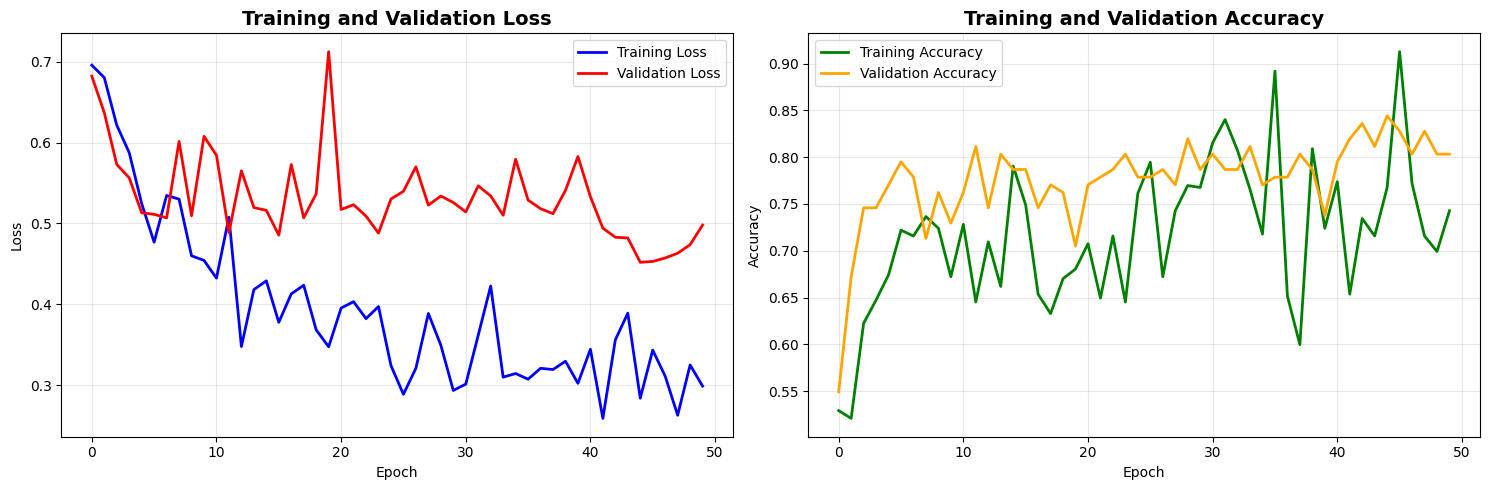

In [ ]:
# Final: visualize train/val loss and train/val accuracy side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training and validation loss
ax1.plot(metrics.train_losses, label='Training Loss', color='blue', linewidth=2)
ax1.plot(metrics.val_losses, label='Validation Loss', color='red', linewidth=2)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot training and validation accuracy
ax2.plot(metrics.train_accs, label='Training Accuracy', color='green', linewidth=2)
ax2.plot(metrics.val_accs, label='Validation Accuracy', color='orange', linewidth=2)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'training_history.png'), dpi=150, bbox_inches='tight')
plt.show()


### Version2 Updates

Here's what have been done to prevent overfitting, and make changes compared to version 1:
- Scheduler: `ReduceLROnPlateau` on validation loss. `lr` starts at 1e-4, and decays at a factor of 0.8 if for 4 epoches it does not significantly changed; the `min_lr` is set to 3e-5.
- Mixup is active longer than before. So it still works after initial training epoches
- Loss/optim:  `AdamW` with increase `weight_decay=3e-4`.
- `batch_size` is reduced to 32.

In [ ]:
## 8. Continue training with lower scheduler min_lr (1e-5)

import os
import contextlib
from glob import glob
import torch

@contextlib.contextmanager
def force_scheduler_min_lr(min_lr_value: float = 1e-5):
    """
    Temporarily override torch.optim.lr_scheduler.ReduceLROnPlateau to force a specific min_lr.
    Useful for resuming training with a lower floor without editing the original training function.
    """
    original_reduce = torch.optim.lr_scheduler.ReduceLROnPlateau
    def patched_reduce(optimizer, *args, **kwargs):
        kwargs['min_lr'] = min_lr_value
        return original_reduce(optimizer, *args, **kwargs)
    torch.optim.lr_scheduler.ReduceLROnPlateau = patched_reduce
    try:
        yield
    finally:
        torch.optim.lr_scheduler.ReduceLROnPlateau = original_reduce


In [ ]:
# Find latest checkpoint in SAVE_DIR and continue training for 30 epochs with min_lr=1e-5

# Ensure paths are correct
assert SAVE_DIR == '/content/drive/MyDrive/vitiligo/results/v2', f"Unexpected SAVE_DIR: {SAVE_DIR}"

# Try to locate a reasonable checkpoint to resume from
candidate_patterns = [
    os.path.join(SAVE_DIR, 'best_checkpoint.pth'),
    os.path.join(SAVE_DIR, 'best_model_weights.pth'),
    os.path.join(SAVE_DIR, 'best_model_acc_*.pth'),
]

ckpt_path = None
for pattern in candidate_patterns:
    matches = sorted(glob(pattern), key=os.path.getmtime, reverse=True)
    if matches:
        ckpt_path = matches[0]
        break

if ckpt_path is None:
    raise FileNotFoundError(f"No checkpoint found in {SAVE_DIR}. Make sure a prior run saved weights.")

print(f"Resuming from: {ckpt_path}")

# Prefer the dict with model+optimizer if available
resume_arg = ckpt_path if ckpt_path.endswith('.pth') else None

# Continue training for 30 more epochs, keep original LR and other configs
# but force scheduler min_lr to 1e-5 via the context manager above.
with force_scheduler_min_lr(1e-5):
    model2, metrics2 = train_vitiligo_model(
        epochs=30,
        batch_size=32,
        learning_rate=3e-5,
        val_ratio=0.2,
        num_workers=4,
        pretrained=True,
        resume_from=resume_arg,
        reset_optimizer=False,
    )

# Optionally, visualize the continued history if desired
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(metrics2.train_losses, label='Training Loss (cont)', color='blue', linewidth=2)
ax1.plot(metrics2.val_losses, label='Validation Loss (cont)', color='red', linewidth=2)
ax1.legend(); ax1.set_title('Loss (continued)'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.grid(True, alpha=0.3)
ax2.plot(metrics2.train_accs, label='Training Acc (cont)', color='green', linewidth=2)
ax2.plot(metrics2.val_accs, label='Validation Acc (cont)', color='orange', linewidth=2)
ax2.legend(); ax2.set_title('Accuracy (continued)'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('Acc'); ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'training_history_continued.png'), dpi=150, bbox_inches='tight')
plt.show()


Resuming from: /content/drive/MyDrive/vitiligo/results/v2/best_checkpoint.pth
🚀 VITILIGO CLASSIFICATION WITH MASK-GUIDED ATTENTION

📋 Loading segmentation model...
✅ Mask predictor initialized (CPU model loaded; will use GPU 'NVIDIA A100-SXM4-40GB' with AMP=True when called from main process).

📊 Splitting dataset...
progressive_stage_patient: Train 237, Val 60
stable_stage_patient: Train 245, Val 62
Total: 482 train samples, 122 val samples

🔧 Initializing model...

♻️  Resuming from checkpoint: /content/drive/MyDrive/vitiligo/results/v2/best_checkpoint.pth
   ✅ Starting from epoch 1

🎯 Training Configuration:
   • Epochs: 30
   • Batch Size: 32
   • Learning Rate: 3e-05
   • Mixed Precision: Enabled
   • Device: cuda

📈 STARTING TRAINING

EPOCH 1/30


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 1 Results:
   Train - Loss: 0.3937, Acc: 0.6349, Spec: 0.6531, Sens: 0.6160
   Val   - Loss: 0.4745, Acc: 0.8197, Spec: 0.8387, Sens: 0.8000
   LR: 0.000030 | Gap -0.185

EPOCH 2/30


Training:   0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
## 9. Visualize combined curves over full training (metrics + metrics2)

import os
import matplotlib.pyplot as plt

if 'metrics' not in globals() or 'metrics2' not in globals():
    raise RuntimeError("Both 'metrics' (first run) and 'metrics2' (continued run) must exist. Run the training cells first.")

# Concatenate metrics from the first 50 epochs and the next 30 epochs
train_losses_full = list(metrics.train_losses) + list(metrics2.train_losses)
val_losses_full   = list(metrics.val_losses)   + list(metrics2.val_losses)
train_accs_full   = list(metrics.train_accs)   + list(metrics2.train_accs)
val_accs_full     = list(metrics.val_accs)     + list(metrics2.val_accs)

total_epochs = len(train_losses_full)
split_epoch = len(metrics.train_losses)
epochs_full = list(range(1, total_epochs + 1))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss
ax1.plot(epochs_full, train_losses_full, label='Training Loss', color='blue', linewidth=2)
ax1.plot(epochs_full, val_losses_full, label='Validation Loss', color='red', linewidth=2)
ax1.axvline(split_epoch, color='gray', linestyle='--', alpha=0.6)
# Annotate resume point
try:
    y_annot_loss = max(max(train_losses_full), max(val_losses_full)) * 0.98
except ValueError:
    y_annot_loss = 0.0
ax1.text(split_epoch + 0.5, y_annot_loss, 'resume', rotation=90, color='gray')
ax1.set_title(f'Training and Validation Loss (1-{total_epochs} epochs)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True, alpha=0.3)

# Accuracy
ax2.plot(epochs_full, train_accs_full, label='Training Accuracy', color='green', linewidth=2)
ax2.plot(epochs_full, val_accs_full, label='Validation Accuracy', color='orange', linewidth=2)
ax2.axvline(split_epoch, color='gray', linestyle='--', alpha=0.6)
try:
    y_annot_acc = max(max(train_accs_full), max(val_accs_full)) * 0.98
except ValueError:
    y_annot_acc = 1.0
ax2.text(split_epoch + 0.5, y_annot_acc, 'resume', rotation=90, color='gray')
ax2.set_title(f'Training and Validation Accuracy (1-{total_epochs} epochs)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy'); ax2.legend(); ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'training_history_80epochs.png'), dpi=150, bbox_inches='tight')
plt.show()


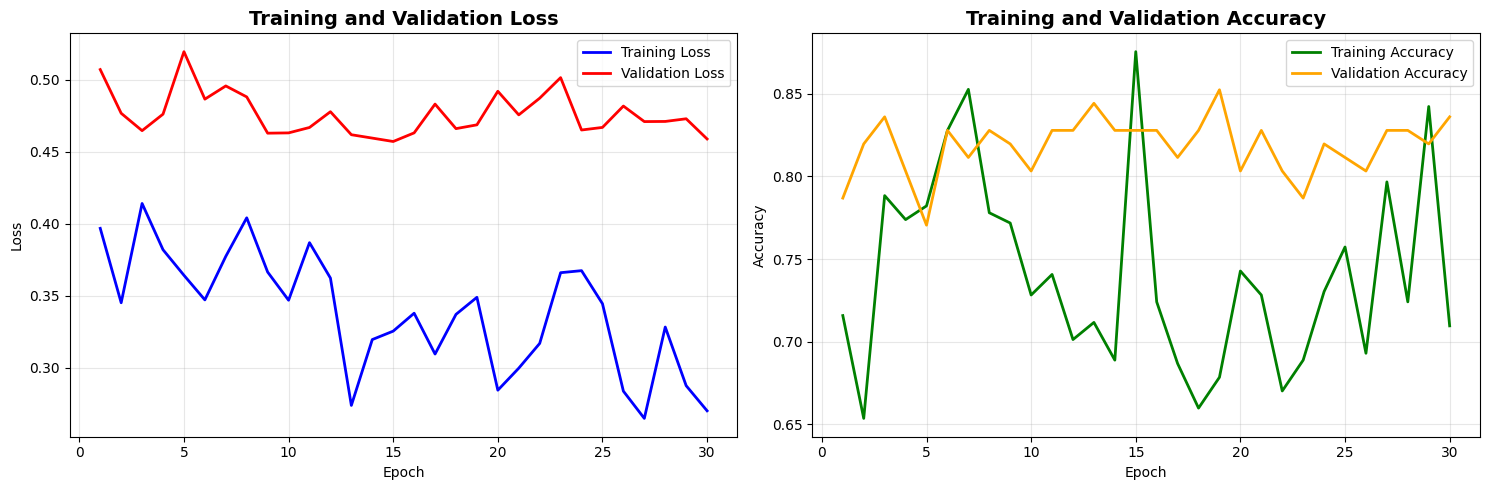

In [ ]:
print